In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

In [4]:
import tensorflow as tf
tf

<module 'tensorflow' from 'D:\\Anaconda3\\Lib\\site-packages\\tensorflow\\__init__.py'>

In [5]:
tf

<module 'tensorflow' from 'D:\\Anaconda3\\Lib\\site-packages\\tensorflow\\__init__.py'>

In [6]:
import os

BASE_PATH = "D:\cubicasa5k"

print(os.listdir(BASE_PATH))


['colorful', 'high_quality', 'high_quality_architectural', 'test.txt', 'train.txt', 'val.txt']


In [7]:
subset_path = os.path.join(BASE_PATH, "high_quality")
print(os.listdir(subset_path))


['10004', '10010', '10014', '10017', '10037', '10064', '1007', '10072', '10083', '10112', '10132', '10135', '10173', '1019', '10191', '10199', '10210', '10221', '10241', '1025', '10282', '10293', '10297', '103', '10306', '10316', '10332', '10334', '1034', '10346', '1035', '10356', '1036', '10360', '10362', '10385', '10386', '1039', '10391', '10392', '10395', '10403', '10408', '10413', '10414', '10422', '10423', '10441', '10443', '10457', '10458', '10470', '10504', '10519', '10525', '10538', '10541', '10552', '10568', '10586', '10587', '10602', '10615', '10635', '10666', '10669', '10674', '10676', '10689', '107', '1072', '10721', '10722', '10748', '10757', '10776', '1078', '10785', '10789', '10796', '108', '1081', '1082', '1092', '1095', '1097', '11038', '11039', '11078', '11088', '11091', '11095', '11107', '11131', '11132', '1115', '11186', '11197', '11208', '11211', '11221', '11246', '11255', '11256', '11262', '11263', '11271', '11272', '11296', '11317', '11357', '11362', '11365', '11

In [8]:
sample_id = "10004"
sample_path = os.path.join(BASE_PATH, "high_quality", sample_id)

print(os.listdir(sample_path))


['F1_original.png', 'F1_scaled.png', 'mask_full.png', 'model.svg']


In [9]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


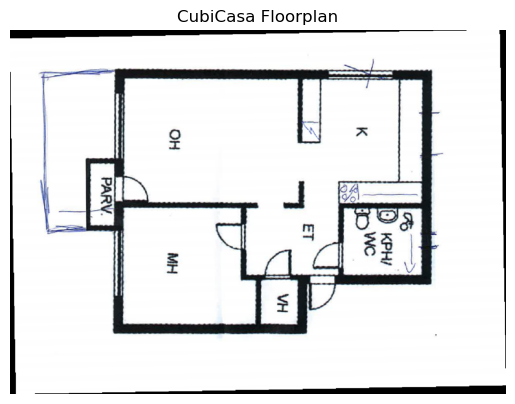

In [10]:
import cv2
import matplotlib.pyplot as plt
import os

img_path = os.path.join(sample_path, "F1_scaled.png")

img = cv2.imread(img_path)

# ALWAYS check this before cvtColor
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("CubiCasa Floorplan")
plt.axis("off")
plt.show()


In [11]:
pip install lxml svgpathtools shapely


Note: you may need to restart the kernel to use updated packages.


In [12]:
from lxml import etree

svg_path = os.path.join(sample_path, "model.svg")
tree = etree.parse(svg_path)
root = tree.getroot()

ns = {"svg": "http://www.w3.org/2000/svg"}

print("Top-level tags:")
for child in root:
    print(child.tag)


Top-level tags:
{http://www.w3.org/2000/svg}defs
{http://www.w3.org/2000/svg}g


In [13]:
pip install svglib reportlab pillow

In [87]:
import subprocess

inkscape_path = r"D:\Inkscape\bin\inkscape.exe"  # adjust if needed

subprocess.run([inkscape_path, "--version"], check=True)


CompletedProcess(args=['D:\\Inkscape\\bin\\inkscape.exe', '--version'], returncode=0)

In [88]:
import os
import subprocess

inkscape = r"D:\Inkscape\bin\inkscape.exe"  # adjust if needed

svg_path = os.path.join(sample_path, "model.svg")
out_png = os.path.join(sample_path, "mask_full.png")

cmd = [
    inkscape,
    svg_path,
    "--export-type=png",
    "--export-filename", out_png,
    "--export-width=1024",
    "--export-height=1024"
]

subprocess.run(cmd, check=True)
print("Saved:", out_png)



Saved: D:\cubicasa5k\high_quality\10004\mask_full.png


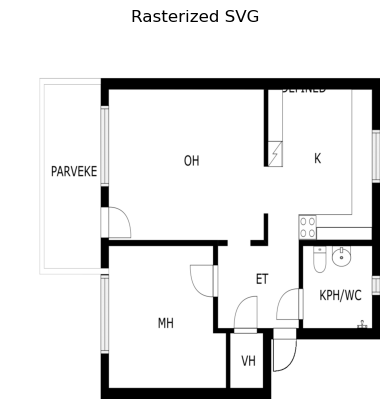

In [89]:
import cv2
import matplotlib.pyplot as plt

mask = cv2.imread(out_png, cv2.IMREAD_GRAYSCALE)

plt.imshow(mask, cmap="gray")
plt.title("Rasterized SVG")
plt.axis("off")
plt.show()


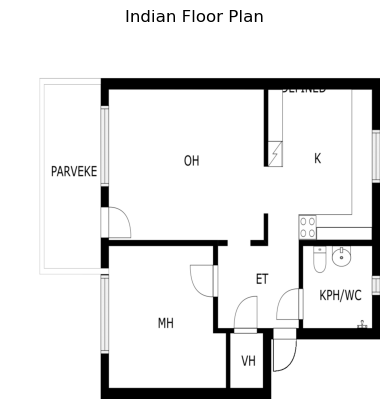

In [90]:
import cv2
import matplotlib.pyplot as plt

# img_path = r"D:\floor.jpg"   # <-- your Indian plan

img = cv2.imread(out_png, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Indian Floor Plan")
plt.show()


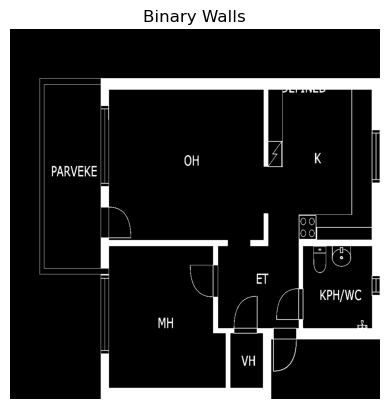

In [91]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread(out_png, cv2.IMREAD_GRAYSCALE)
# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Invert so walls = white
# remove text by blurring
img_blur = cv2.GaussianBlur(img, (7,7), 0)
_, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap="gray")
plt.title("Binary Walls")
plt.axis("off")
plt.show()


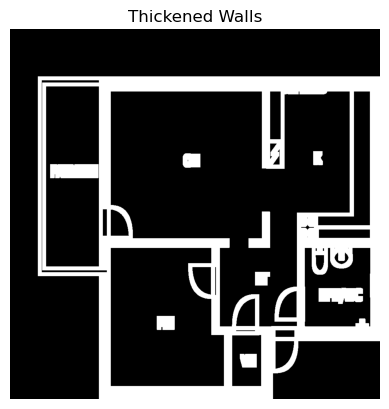

In [92]:
# kernel = np.ones((7,7), np.uint8)
# walls = cv2.dilate(binary, kernel, iterations=1)

# kernel = np.ones((9,9), np.uint8)
# walls = cv2.dilate(binary, kernel, iterations=1)

kernel = np.ones((11,11), np.uint8)  # bigger kernel closes door gaps
walls = cv2.dilate(binary, kernel, iterations=1)


plt.imshow(walls, cmap="gray")
plt.title("Thickened Walls")
plt.axis("off")
plt.show()


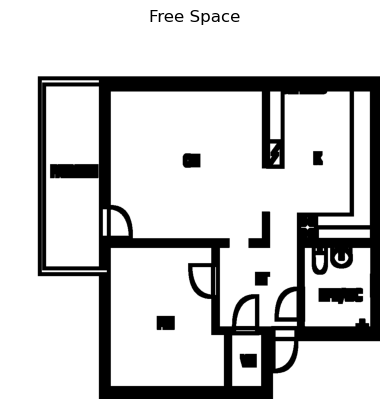

In [93]:
free_space = cv2.bitwise_not(walls)

plt.imshow(free_space, cmap="gray")
plt.title("Free Space")
plt.axis("off")
plt.show()


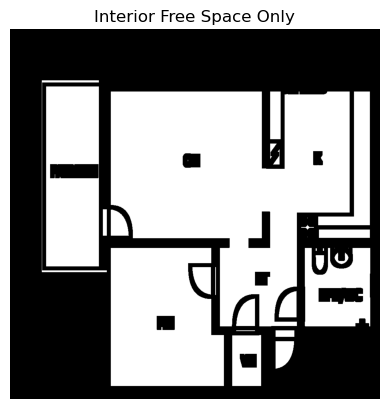

In [94]:
# h, w = free_space.shape
# mask = np.zeros((h+2, w+2), np.uint8)

# floodfill = free_space.copy()
# cv2.floodFill(floodfill, mask, (0,0), 0)

h, w = free_space.shape
floodfill = free_space.copy()
mask = np.zeros((h+2, w+2), np.uint8)

# try multiple corners to guarantee exterior
for seed in [(0,0), (w-1,0), (0,h-1), (w-1,h-1)]:
    cv2.floodFill(floodfill, mask, seed, 0)

plt.imshow(floodfill, cmap="gray")
plt.title("Interior Free Space Only")
plt.axis("off")
plt.show()


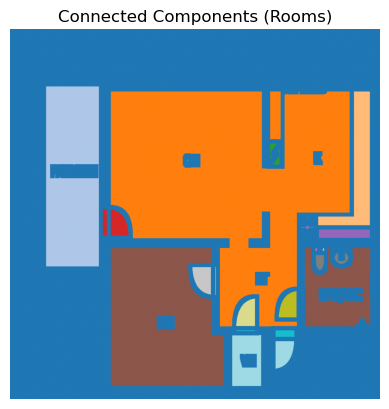

In [95]:
from skimage.measure import label, regionprops

labels = label(floodfill)

plt.imshow(labels, cmap="tab20")
plt.title("Connected Components (Rooms)")
plt.axis("off")
plt.show()


In [96]:
rooms = []

for r in regionprops(labels):
    if r.area < 1500:
        continue
    rooms.append(r)

MIN_ROOM_AREA = 4000  # tune: 3000–6000

rooms = [r for r in rooms if r.area > MIN_ROOM_AREA]
print("Rooms detected:", len(rooms))


Rooms detected: 6


In [97]:
kernel = np.ones((9,9), np.uint8)
walls = cv2.dilate(binary, kernel, iterations=1)


In [98]:
import shapely.geometry as geom

room_polys = []
for r in rooms:
    coords = r.coords[:, ::-1]  # (row,col) → (x,y)
    poly = geom.Polygon(coords)
    room_polys.append(poly)


In [99]:
MERGE_RATIO = 0.35  # small room threshold

merged = []
used = set()

for i, p in enumerate(room_polys):
    if i in used:
        continue

    area_i = p.area
    neighbors = []

    for j, q in enumerate(room_polys):
        if i == j:
            continue
        if p.touches(q):
            neighbors.append((j, q))

    # merge small regions touching one large region
    if area_i < MERGE_RATIO * max([q.area for _, q in neighbors] + [area_i]):
        for j, q in neighbors:
            if q.area > area_i:
                p = p.union(q)
                used.add(j)

    merged.append(p)
    used.add(i)

final_rooms = merged
print("Final rooms:", len(final_rooms))


Final rooms: 6


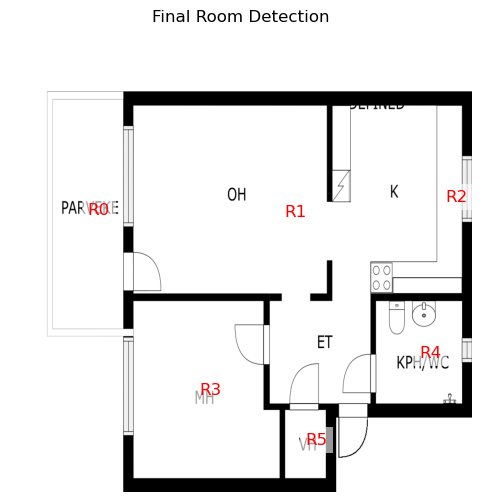

In [100]:
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")

for i, r in enumerate(rooms):
    y, x = r.centroid
    plt.text(x, y, f"R{i}", color="red", fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))


plt.axis("off")
plt.title("Final Room Detection")
plt.show()


In [101]:
from skimage.measure import regionprops

regions = regionprops(labels)



In [102]:
rooms = []
H, W = img.shape

for idx, r in enumerate(regions):
    if r.area < 1500:   # keep your Phase-1 noise filter
        continue

    rooms.append({
        "id": idx,
        "area": r.area,
        "bbox": r.bbox,          # (min_row, min_col, max_row, max_col)
        "centroid": r.centroid,  # (row, col)
        "mask": (labels == r.label)
    })

len(rooms)


14

In [103]:
import cv2
import numpy as np

def are_adjacent(mask1, mask2):
    kernel = np.ones((3,3), np.uint8)
    m1 = cv2.dilate(mask1.astype(np.uint8), kernel, iterations=1)
    return np.any(m1 & mask2)


In [104]:
adjacency = {r["id"]: set() for r in rooms}

for i in range(len(rooms)):
    for j in range(i + 1, len(rooms)):
        if are_adjacent(rooms[i]["mask"], rooms[j]["mask"]):
            adjacency[rooms[i]["id"]].add(rooms[j]["id"])
            adjacency[rooms[j]["id"]].add(rooms[i]["id"])

adjacency


{0: set(),
 1: set(),
 2: set(),
 3: set(),
 4: set(),
 9: set(),
 12: set(),
 14: set(),
 15: set(),
 22: set(),
 24: set(),
 25: set(),
 28: set(),
 29: set()}

In [105]:
layout_center = (
    np.mean([r["centroid"][0] for r in rooms]),
    np.mean([r["centroid"][1] for r in rooms])
)


In [106]:
def get_direction(centroid, center):
    dy = centroid[0] - center[0]
    dx = centroid[1] - center[1]

    if abs(dx) > abs(dy):
        return "E" if dx > 0 else "W"
    else:
        return "S" if dy > 0 else "N"


In [107]:
for r in rooms:
    r["direction"] = get_direction(r["centroid"], layout_center)

[(r["id"], r["direction"]) for r in rooms]


[(0, 'W'),
 (1, 'W'),
 (2, 'N'),
 (3, 'N'),
 (4, 'E'),
 (9, 'W'),
 (12, 'E'),
 (14, 'S'),
 (15, 'E'),
 (22, 'S'),
 (24, 'E'),
 (25, 'S'),
 (28, 'S'),
 (29, 'S')]

In [108]:
for r in rooms:
    r["degree"] = len(adjacency[r["id"]])

[(r["id"], r["degree"]) for r in rooms]


[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (9, 0),
 (12, 0),
 (14, 0),
 (15, 0),
 (22, 0),
 (24, 0),
 (25, 0),
 (28, 0),
 (29, 0)]

In [109]:
def bbox_adjacent(b1, b2, tol=15):
    r1_min, c1_min, r1_max, c1_max = b1
    r2_min, c2_min, r2_max, c2_max = b2

    # horizontal adjacency (left-right)
    vertical_overlap = min(r1_max, r2_max) - max(r1_min, r2_min)
    horizontal_touch = abs(c1_max - c2_min) <= tol or abs(c2_max - c1_min) <= tol

    # vertical adjacency (top-bottom)
    horizontal_overlap = min(c1_max, c2_max) - max(c1_min, c2_min)
    vertical_touch = abs(r1_max - r2_min) <= tol or abs(r2_max - r1_min) <= tol

    if vertical_overlap > tol and horizontal_touch:
        return True
    if horizontal_overlap > tol and vertical_touch:
        return True

    return False


In [110]:
adjacency = {r["id"]: set() for r in rooms}

for i in range(len(rooms)):
    for j in range(i + 1, len(rooms)):
        if bbox_adjacent(rooms[i]["bbox"], rooms[j]["bbox"]):
            adjacency[rooms[i]["id"]].add(rooms[j]["id"])
            adjacency[rooms[j]["id"]].add(rooms[i]["id"])

adjacency


{0: {2, 9, 14},
 1: set(),
 2: {0},
 3: set(),
 4: {12},
 9: {0},
 12: {4},
 14: {0},
 15: set(),
 22: set(),
 24: set(),
 25: set(),
 28: set(),
 29: set()}

In [111]:
for r in rooms:
    r["neighbors"] = list(adjacency[r["id"]])
    r["degree"] = len(adjacency[r["id"]])


In [112]:
import numpy as np

layout_center = (
    np.mean([r["centroid"][0] for r in rooms]),  # row (y)
    np.mean([r["centroid"][1] for r in rooms])   # col (x)
)

layout_center


(np.float64(610.168236459224), np.float64(610.9086366290055))

In [113]:
def get_direction(centroid, center):
    dy = centroid[0] - center[0]  # vertical (row)
    dx = centroid[1] - center[1]  # horizontal (col)

    if abs(dx) > abs(dy):
        return "E" if dx > 0 else "W"
    else:
        return "S" if dy > 0 else "N"


In [114]:
for r in rooms:
    r["direction"] = get_direction(r["centroid"], layout_center)


In [115]:
[(r["id"], r["direction"]) for r in rooms]


[(0, 'W'),
 (1, 'W'),
 (2, 'N'),
 (3, 'N'),
 (4, 'E'),
 (9, 'W'),
 (12, 'E'),
 (14, 'S'),
 (15, 'E'),
 (22, 'S'),
 (24, 'E'),
 (25, 'S'),
 (28, 'S'),
 (29, 'S')]

In [116]:
for i, r in enumerate(rooms):
    r["id"] = i


In [117]:
areas = [r["area"] for r in rooms]
avg_area = sum(areas) / len(areas)

for r in rooms:
    r["is_large"] = r["area"] > avg_area * 1.2
    r["is_small"] = r["area"] < avg_area * 0.6
    r["is_isolated"] = r["degree"] == 0
    r["is_central"] = r["degree"] >= 2


In [118]:
def infer_room_type(r):
    # Living / Hall
    if r["is_large"] and r["is_central"]:
        return "Living / Hall"

    # Kitchen (Indian layouts)
    if r["direction"] in ["E", "SE"] and not r["is_isolated"]:
        return "Kitchen"

    # Bedroom
    if r["direction"] in ["N", "W", "SW"] and not r["is_isolated"]:
        return "Bedroom"

    # Toilet / Utility
    if r["is_small"] and r["is_isolated"]:
        return "Toilet / Utility"

    # Balcony / Store
    if r["is_isolated"]:
        return "Balcony / Store"

    return "Unknown"


In [119]:
for r in rooms:
    r["room_type"] = infer_room_type(r)

[(r["id"], r["room_type"]) for r in rooms]


[(0, 'Bedroom'),
 (1, 'Balcony / Store'),
 (2, 'Bedroom'),
 (3, 'Toilet / Utility'),
 (4, 'Kitchen'),
 (5, 'Bedroom'),
 (6, 'Kitchen'),
 (7, 'Unknown'),
 (8, 'Balcony / Store'),
 (9, 'Toilet / Utility'),
 (10, 'Toilet / Utility'),
 (11, 'Toilet / Utility'),
 (12, 'Toilet / Utility'),
 (13, 'Toilet / Utility')]

In [120]:
def vastu_checks(room):
    issues = []

    if room["room_type"] == "Kitchen" and room["direction"] not in ["E", "SE"]:
        issues.append("Kitchen should be in East / South-East")

    if room["room_type"] == "Toilet / Utility" and room["direction"] == "NE":
        issues.append("Toilet in North-East is not recommended")

    if room["room_type"] == "Bedroom" and room["direction"] == "NE":
        issues.append("Bedroom in North-East is discouraged")

    return issues


In [121]:
for r in rooms:
    r["vastu_issues"] = vastu_checks(r)


In [122]:
for r in rooms:
    if r["vastu_issues"]:
        print(f"Room {r['id']} ({r['room_type']}):")
        for issue in r["vastu_issues"]:
            print("  -", issue)


In [59]:
### Heatmap & Explanation Layers

In [123]:
def get_zone(centroid, img_shape):
    h, w = img_shape
    y, x = centroid

    row = int(3 * y / h)
    col = int(3 * x / w)

    zones = [
        ["NW", "N", "NE"],
        ["W",  "C", "E"],
        ["SW", "S", "SE"]
    ]

    return zones[min(row, 2)][min(col, 2)]


In [124]:
for r in rooms:
    r["zone"] = get_zone(r["centroid"], img.shape)

[(r["id"], r["room_type"], r["zone"]) for r in rooms]


[(0, 'Bedroom', 'W'),
 (1, 'Balcony / Store', 'W'),
 (2, 'Bedroom', 'C'),
 (3, 'Toilet / Utility', 'NE'),
 (4, 'Kitchen', 'E'),
 (5, 'Bedroom', 'W'),
 (6, 'Kitchen', 'E'),
 (7, 'Unknown', 'S'),
 (8, 'Balcony / Store', 'SE'),
 (9, 'Toilet / Utility', 'S'),
 (10, 'Toilet / Utility', 'SE'),
 (11, 'Toilet / Utility', 'S'),
 (12, 'Toilet / Utility', 'S'),
 (13, 'Toilet / Utility', 'SE')]

In [125]:
VASTU_RULES = {
    "Kitchen": {
        "good": ["E", "SE"],
        "bad": ["NE", "SW"]
    },
    "Bedroom": {
        "good": ["SW", "W"],
        "bad": ["NE"]
    },
    "Service Space": {
        "good": ["S", "W"],
        "bad": ["NE"]
    }
}


In [126]:
def vastu_score(room):
    rules = VASTU_RULES.get(room["room_type"])
    if not rules:
        return 0, "No rule"

    if room["zone"] in rules["good"]:
        return +1, "Good placement"
    if room["zone"] in rules["bad"]:
        return -1, "Poor placement"

    return 0, "Neutral"


In [127]:
for r in rooms:
    r["vastu_score"], r["vastu_reason"] = vastu_score(r)


In [128]:
import numpy as np

heatmap = np.zeros((3,3))

zone_to_idx = {
    "NW": (0,0), "N": (0,1), "NE": (0,2),
    "W": (1,0),  "C": (1,1),  "E": (1,2),
    "SW": (2,0), "S": (2,1),  "SE": (2,2)
}

for r in rooms:
    i, j = zone_to_idx[r["zone"]]
    heatmap[i, j] += r["vastu_score"]


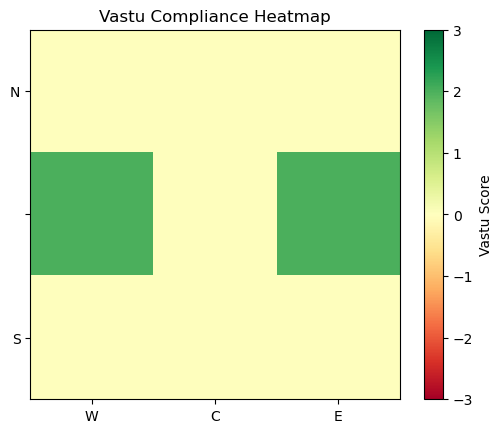

In [129]:
import matplotlib.pyplot as plt

plt.imshow(heatmap, cmap="RdYlGn", vmin=-3, vmax=3)
plt.colorbar(label="Vastu Score")
plt.title("Vastu Compliance Heatmap")
plt.xticks(range(3), ["W", "C", "E"])
plt.yticks(range(3), ["N", "", "S"])
plt.show()


In [130]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Convert grayscale to color for overlay
overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)


In [131]:
VASTU_COLORS = {
    +1: (0, 255, 0),     # bright green
     0: (255, 255, 0),   # bright yellow
    -1: (0, 0, 255)      # bright red
}
alpha = 0.9


In [132]:
alpha = 1  # transparency

for r in rooms:
    color = VASTU_COLORS.get(r["vastu_score"], (200, 200, 200))
    mask = r["mask"]

    # Create colored layer
    colored = np.zeros_like(overlay)
    colored[mask] = color

    # Blend with overlay
    overlay = cv2.addWeighted(overlay, 1, colored, alpha, 0)


In [133]:
for r in rooms:
    y, x = map(int, r["centroid"])
    label = f"{r['room_type']} ({r['vastu_score']})"

    cv2.putText(
        overlay,
        label,
        (x - 40, y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.4,
        (0, 0, 0),
        1,
        cv2.LINE_AA
    )


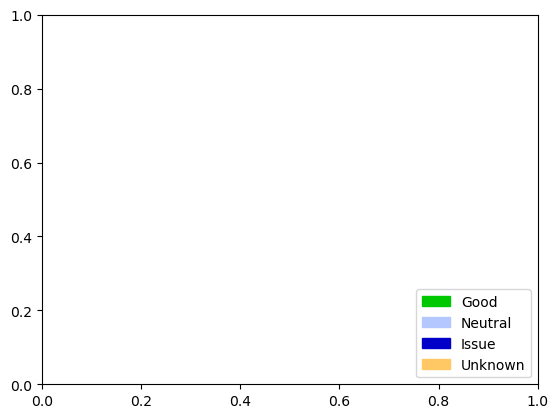

In [134]:
import matplotlib.patches as mpatches

legend = [
    mpatches.Patch(color=(0/255,200/255,0/255), label="Good"),
    mpatches.Patch(color=(180/255,200/255,255/255), label="Neutral"),
    mpatches.Patch(color=(0/255,0/255,200/255), label="Issue"),
    mpatches.Patch(color=(255/255,200/255,100/255), label="Unknown"),
]

plt.legend(handles=legend, loc="lower right")


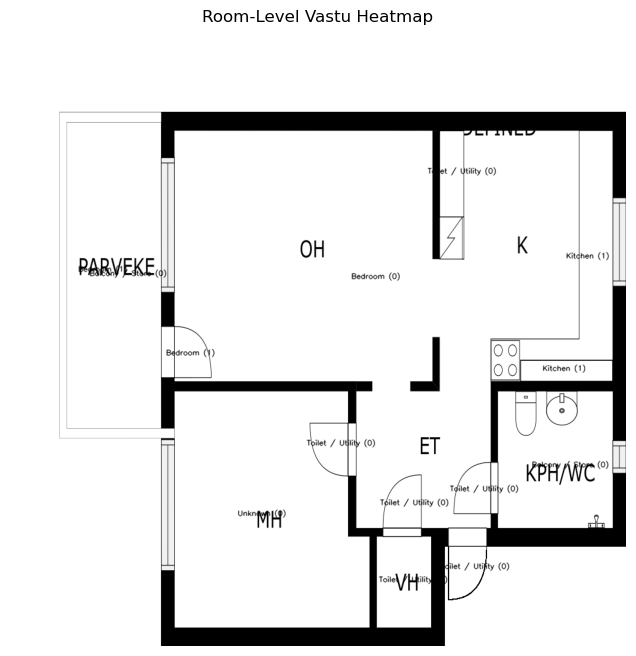

In [135]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Room-Level Vastu Heatmap")
plt.axis("off")
plt.show()


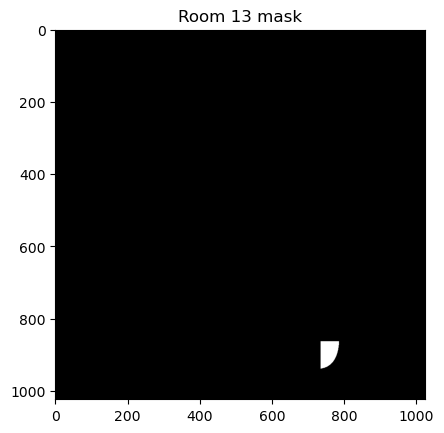

In [136]:
plt.imshow(r["mask"], cmap="gray")
plt.title(f"Room {r['id']} mask")
plt.show()


In [63]:
from skimage.measure import label, regionprops

labels = label(free_space > 0)
# dont execute this, this is casuing issues
rooms = []
for r in regionprops(labels):
    if r.area < 3000:
        continue

    mask = labels == r.label

    rooms.append({
        "id": len(rooms),
        "mask": mask,
        "area": r.area,
        "centroid": r.centroid
    })


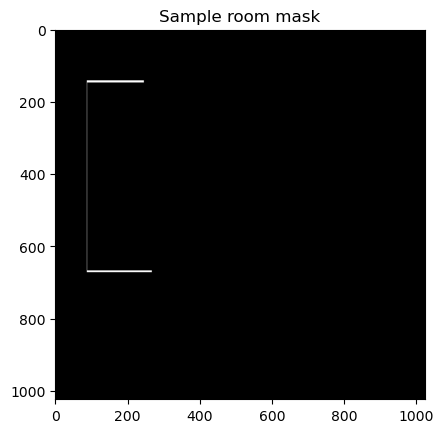

In [137]:
plt.imshow(rooms[0]["mask"], cmap="gray")
plt.title("Sample room mask")
plt.show()


In [138]:
H, W = img.shape[:2]

def get_direction_from_centroid(centroid):
    y, x = centroid

    vertical = "N" if y < H / 2 else "S"
    horizontal = "W" if x < W / 2 else "E"

    return vertical + horizontal
for r in rooms:
    r["direction"] = get_direction_from_centroid(r["centroid"])


In [139]:
for r in rooms:
    r["features"] = {
        "area": r["area"],
        "direction": r["direction"],
        "adjacent_count": len(adjacency.get(r["id"], [])),
        "is_corner": r["direction"] in ["NE", "NW", "SE", "SW"],
        "room_type": r["room_type"]
    }


In [140]:
def vastu_score_zone(r):
    score = 0
    reasons = []

    if r["room_type"] == "Kitchen":
        if r["direction"] in ["SE", "E"]:
            score += 2
            reasons.append("Kitchen placed in favorable direction")
        elif r["direction"] == "NE":
            score -= 2
            reasons.append("Kitchen in NE is discouraged")

    if r["room_type"] == "Bedroom":
        if r["direction"] == "SW":
            score += 2
            reasons.append("Bedroom in SW is ideal")
        elif r["direction"] == "NE":
            score -= 1
            reasons.append("Bedroom in NE may disturb rest")

    if r["room_type"] == "Toilet / Utility":
        if r["direction"] == "NE":
            score -= 3
            reasons.append("Toilet in NE is a major issue")

    return score, reasons


In [141]:
for r in rooms:
    r["vastu_score"], r["vastu_reasons"] = vastu_score_zone(r)


In [142]:
heatmap = np.full(img.shape[:2], np.nan, dtype=np.float32)


for r in rooms:
    y, x = map(int, r["centroid"])
    cv2.circle(
        heatmap,
        (x, y),
        radius=int(np.sqrt(r["area"]) // 2),
        color=r["vastu_score"],
        thickness=-1
    )



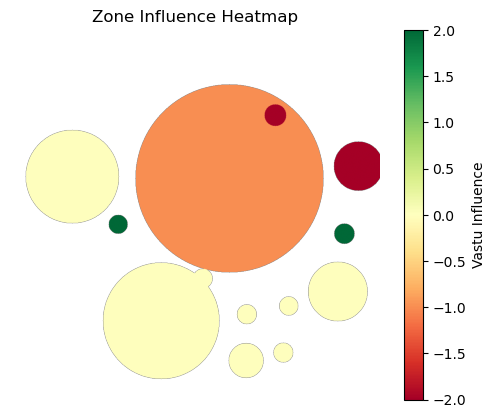

In [143]:
masked = np.ma.masked_invalid(heatmap)

plt.imshow(masked, cmap="RdYlGn", vmin=-2, vmax=2)
plt.colorbar(label="Vastu Influence")
plt.title("Zone Influence Heatmap")
plt.axis("off")
plt.show()


In [144]:
for r in rooms:
    if r["vastu_score"] < 0:
        print(f"⚠️ Zone {r['id']} ({r['room_type']}):")
        for reason in r["vastu_reasons"]:
            print("  -", reason)


⚠️ Zone 2 (Bedroom):
  - Bedroom in NE may disturb rest
⚠️ Zone 3 (Toilet / Utility):
  - Toilet in NE is a major issue
⚠️ Zone 4 (Kitchen):
  - Kitchen in NE is discouraged


In [147]:
# Total floor area = sum of all detected room areas
total_floor_area = sum(r["area"] for r in rooms)

print("Total floor area:", total_floor_area)


Total floor area: 522749.0


In [153]:
cx_house = W / 2
cy_house = H / 2

for r in rooms:
    cx, cy = r["centroid"]

    if cx >= cx_house and cy < cy_house:
        zone = "NE"
    elif cx < cx_house and cy < cy_house:
        zone = "NW"
    elif cx >= cx_house and cy >= cy_house:
        zone = "SE"
    else:
        zone = "SW"

    r["vastu_zone"] = zone


In [155]:
import pandas as pd

rows = []

H, W = img.shape[:2]  # use your loaded image

for r in rooms:
    cx, cy = r["centroid"]

    row = {
        "room_id": r["id"],
        "area_ratio": r["area"] / total_floor_area,
        "centroid_x": cx / W,
        "centroid_y": cy / H,
        "direction": r["direction"],
        "adj_count": len(adjacency.get(r["id"], [])),
        "touches_boundary": int(
         r["centroid"][0] < 10 or
         r["centroid"][0] > W - 10 or
         r["centroid"][1] < 10 or
         r["centroid"][1] > H - 10
        ),
        "open_ratio": r.get("open_ratio", 0.0),
        "vastu_zone": r["vastu_zone"]
    }

    rows.append(row)

rooms_df = pd.DataFrame(rows)
rooms_df


,room_id,area_ratio,centroid_x,centroid_y,direction,adj_count,touches_boundary,open_ratio,vastu_zone
0,0,0.004530,0.392558,0.149846,NW,3,0,0.0,NW
1,1,0.129142,0.399042,0.168067,NW,0,0,0.0,NW
2,2,0.519502,0.403652,0.592913,NE,1,0,0.0,SW
3,3,0.007323,0.232910,0.716797,NE,0,0,0.0,SW
4,4,0.035688,0.370638,0.941791,NE,1,0,0.0,SW
5,5,0.005374,0.528120,0.292516,SW,0,0,0.0,NE
6,6,0.006204,0.552734,0.903320,SE,0,0,0.0,SE
7,7,0.198587,0.788462,0.409140,SW,0,0,0.0,NE
8,8,0.052587,0.709246,0.886284,SE,0,0,0.0,SE
9,9,0.005821,0.674404,0.521197,SE,1,0,0.0,SE


In [156]:
from sklearn.preprocessing import LabelEncoder

dir_encoder = LabelEncoder()
zone_encoder = LabelEncoder()

rooms_df["direction_enc"] = dir_encoder.fit_transform(rooms_df["direction"])
rooms_df["zone_enc"] = zone_encoder.fit_transform(rooms_df["vastu_zone"])

rooms_df


,room_id,area_ratio,centroid_x,centroid_y,direction,adj_count,touches_boundary,open_ratio,vastu_zone,direction_enc,zone_enc
0,0,0.004530,0.392558,0.149846,NW,3,0,0.0,NW,1,1
1,1,0.129142,0.399042,0.168067,NW,0,0,0.0,NW,1,1
2,2,0.519502,0.403652,0.592913,NE,1,0,0.0,SW,0,3
3,3,0.007323,0.232910,0.716797,NE,0,0,0.0,SW,0,3
4,4,0.035688,0.370638,0.941791,NE,1,0,0.0,SW,0,3
5,5,0.005374,0.528120,0.292516,SW,0,0,0.0,NE,3,0
6,6,0.006204,0.552734,0.903320,SE,0,0,0.0,SE,2,2
7,7,0.198587,0.788462,0.409140,SW,0,0,0.0,NE,3,0
8,8,0.052587,0.709246,0.886284,SE,0,0,0.0,SE,2,2
9,9,0.005821,0.674404,0.521197,SE,1,0,0.0,SE,2,2


In [157]:
def vastu_label(row):
    # example bootstrap rules
    if row["vastu_zone"] == "SW" and row["area_ratio"] > 0.25:
        return 1  # risky
    if row["direction"] == "S" and row["touches_boundary"]:
        return 1
    return 0

rooms_df["vastu_risk"] = rooms_df.apply(vastu_label, axis=1)
rooms_df[["room_id", "vastu_risk"]]


,room_id,vastu_risk
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [158]:
feature_cols = [
    "area_ratio",
    "centroid_x",
    "centroid_y",
    "direction_enc",
    "adj_count",
    "touches_boundary",
    "open_ratio",
    "zone_enc"
]

X = rooms_df[feature_cols]
y = rooms_df["vastu_risk"]


In [159]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

rooms_df["ml_risk_score"] = model.predict_proba(X)[:, 1]
rooms_df[["room_id", "ml_risk_score"]]


,room_id,ml_risk_score
0,0,0.076065
1,1,0.040467
2,2,0.243943
3,3,0.173478
4,4,0.208284
5,5,0.006455
6,6,0.032304
7,7,0.006791
8,8,0.032641
9,9,0.041444


In [160]:
importance = pd.Series(
    model.coef_[0],
    index=feature_cols
).sort_values(ascending=False)

importance


zone_enc            0.517469
area_ratio          0.374567
adj_count           0.237987
touches_boundary    0.000000
open_ratio          0.000000
centroid_x         -0.050130
centroid_y         -0.070363
direction_enc      -0.645748
dtype: float64

In [161]:
for r in rooms:
    score = rooms_df.loc[
        rooms_df["room_id"] == r["id"],
        "ml_risk_score"
    ].values[0]

    print(f"Room {r['id']} → Risk Score: {score:.2f}")


Room 0 → Risk Score: 0.08
Room 1 → Risk Score: 0.04
Room 2 → Risk Score: 0.24
Room 3 → Risk Score: 0.17
Room 4 → Risk Score: 0.21
Room 5 → Risk Score: 0.01
Room 6 → Risk Score: 0.03
Room 7 → Risk Score: 0.01
Room 8 → Risk Score: 0.03
Room 9 → Risk Score: 0.04
Room 10 → Risk Score: 0.03
Room 11 → Risk Score: 0.03
Room 12 → Risk Score: 0.04
Room 13 → Risk Score: 0.03


In [162]:
import os
import glob
import json
import numpy as np
import pandas as pd
from tqdm import tqdm


In [163]:
CUBICASA_ROOT = "D:\cubicasa5k"   # root containing SVGs
OUTPUT_DATASET = "D:\room_risk_dataset.csv"

RISK_MIN = 0.0
RISK_MAX = 1.0


In [164]:
def compute_risk_score(room_features: dict) -> float:
    """
    Wrapper over existing vastu-based scoring logic.
    Returns continuous risk score in [0, 1].
    """

    # --- YOUR EXISTING LOGIC HERE ---
    score = 0.0

    # examples (replace with your actual rules)
    score += 0.3 * room_features["area_ratio"]
    score += 0.2 * room_features["adjacency_count"]
    
    if room_features["touches_boundary"]:
        score += 0.1

    if room_features["vastu_zone"] in ["SW", "NE"]:
        score += 0.2

    # --------------------------------

    return float(np.clip(score, RISK_MIN, RISK_MAX))


In [165]:
def extract_room_features(room) -> dict:
    """
    Convert a room object into structured numeric features.
    Uses EXISTING room attributes from your notebook.
    """

    return {
        "area_ratio": room["area_ratio"],
        "centroid_x": room["centroid_x"],
        "centroid_y": room["centroid_y"],
        "adjacency_count": room["adj_count"],
        "touches_boundary": int(room["touches_boundary"]),
        "direction": room["direction"],
        "vastu_zone": room["vastu_zone"],
        "room_type": room["room_type"],
    }


In [166]:
def room_to_sample(room, plan_id: str, room_id: int) -> dict:
    features = extract_room_features(room)
    risk = compute_risk_score(features)

    sample = {
        "plan_id": plan_id,
        "room_id": room_id,
        "room_type": features["room_type"],
        "area_ratio": features["area_ratio"],
        "centroid_x": features["centroid_x"],
        "centroid_y": features["centroid_y"],
        "adjacency_count": features["adjacency_count"],
        "touches_boundary": features["touches_boundary"],
        "direction": features["direction"],
        "vastu_zone": features["vastu_zone"],
        "risk_score": risk,
    }

    return sample


In [181]:
def rasterize_svg(svg_path, out_png, width=1024, height=1024):
    """
    Rasterizes an SVG to PNG using Inkscape CLI.
    """
    cmd = [
        inkscape,
        svg_path,
        "--export-type=png",
        "--export-filename", out_png,
        "--export-width", str(width),
        "--export-height", str(height)
    ]

    subprocess.run(cmd, check=True)
    return out_png



In [175]:
def extract_room_geometry(img):
    """
    Extracts room polygons / masks from rasterized image.
    """
    # MOVE YOUR EXISTING ROOM-SEGMENTATION LOGIC HERE

    room_polygons = []
    room_types = []

    # existing loops / contour logic goes here

    return room_polygons, room_types


In [176]:
def compute_room_features(poly, room_type, full_img):
    """
    Computes geometric + spatial features for one room.
    """

    area_ratio = ...
    cx, cy = ...
    adj_count = ...
    touches_boundary = ...
    direction = ...
    vastu_zone = ...

    return {
        "room_type": room_type,
        "area_ratio": area_ratio,
        "centroid_x": cx,
        "centroid_y": cy,
        "adj_count": adj_count,
        "touches_boundary": touches_boundary,
        "direction": direction,
        "vastu_zone": vastu_zone
    }


In [197]:
import cv2

def extract_rooms_from_svg(svg_path, work_dir=r"D:\cubicasa5k\_tmp"):
    """
    End-to-end room extraction from SVG.
    """

    png_path = os.path.join(work_dir, "mask_full.png")

    # 1. Rasterize (YOUR METHOD)
    rasterize_svg(svg_path, png_path)

    # 2. Load raster image
    img = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)
     # 2. Threshold / preprocess (MOVE THIS IN)
    _, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

    # 3. FIND CONTOURS (THIS WAS MISSING)
    contours, _ = cv2.findContours(
        thresh,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    # 3. Everything BELOW already exists in your notebook
    # ----------------------------------------------------
    # thresholding
    # contour detection
    # room masks
    # adjacency
    # centroid
    # vastu logic
    # ----------------------------------------------------
    room_masks = []
    room_types = []

    for cnt in contours:
      mask = np.zeros_like(img)
      cv2.drawContours(mask, [cnt], -1, 255, -1)
      room_masks.append(mask)
      room_types.append(detect_room_type(cnt))

    rooms = []

    for i, room_mask in enumerate(room_masks):
        room = {
            "room_id": i,
            "room_type": room_types[i],
            "area_ratio": area_ratios[i],
            "centroid_x": centroids[i][0],
            "centroid_y": centroids[i][1],
            "adj_count": adjacencies[i],
            "touches_boundary": boundary_flags[i],
            "direction": directions[i],
            "vastu_zone": vastu_zones[i]
        }
        rooms.append(room)

    return rooms



In [191]:
def process_single_plan(svg_path: str) -> list:
    """
    Processes one CubiCasa SVG and returns room-level samples.
    """

    plan_id = os.path.basename(svg_path).replace(".svg", "")

    # --- YOUR EXISTING FUNCTION ---
    rooms = extract_rooms_from_svg(svg_path)
    # --------------------------------

    samples = []
    for idx, room in enumerate(rooms):
        try:
            sample = room_to_sample(room, plan_id, idx)
            samples.append(sample)
        except Exception as e:
            print(f"Room skipped in {plan_id}: {e}")

    return samples


In [195]:
svg_files = glob.glob(os.path.join(CUBICASA_ROOT, "**/*.svg"), recursive=True)

print(f"Found {len(svg_files)} SVG plans")


Found 5000 SVG plans


In [198]:
all_samples = []

for svg_path in tqdm(svg_files):
    try:
        samples = process_single_plan(svg_path)
        all_samples.extend(samples)
    except Exception as e:
        print(f"Skipping plan {svg_path}: {e}")


100%|██████████| 5000/5000 [2:28:23<00:00,  1.78s/it]       


In [199]:
print(os.getcwd())

C:\Users\Admin


In [201]:
print("df exists:", "df" in globals())


df exists: False


In [200]:
import pandas as pd

df = pd.read_parquet(OUTPUT_DATASET)
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'room_risk_dataset.parquet'

In [202]:
"df" in globals()


False